# Experiment 1: LLava Approach -ViT Encoder/GPT2 Decoder

This experiment tests the LLava style projections using the HuggingFace ViT encoder and the gpt2 decoder. The experiment has two stages as outlined in the LLAva paper.

- **Stage One**: pretrains with the encoder and decoder frozen. The only trainable parameters at this stage are in the MLP used for image projections.

- **Stage Two**: performs fine-tuning with the decodr and MLP unfrozen. The pretrained MLP weights from stage one are loaded as the starting point for the MLP in stage two.

In [ ]:
import os
import sys
import torch
import torch.nn as nn
from transformers import AutoTokenizer
import datetime
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)


"""
Add support for either running in collab by uploading this notebook and
mounting the directory or locally from the room or experiments folder"
"""
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # NOTE: change the drive path if running with a mounted google drive in collab
    project_root = "/content/drive/Othercomputers/My MacBook Pro/image-captioning"
else:
    cwd = os.getcwd()

    if cwd.endswith("experiments"):
        project_root = os.path.abspath(os.path.join(cwd, '..'))
    else:
        project_root = cwd

if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)

if IN_COLAB:
    !pip install evaluate > /dev/null 2>&1
    !pip install pycocoevalcap > /dev/null 2>&1


from vision_language_model import VisionLanguageModel
import train as train
import data_processing as dp
import download_data as get_data
import evaluation as eval


device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")

experiment = "experiment_1"
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root: /content/drive/Othercomputers/My MacBook Pro/image-captioning


In [2]:
# download data, keep it outside of the mounted directory if running in collab to avoid data transfer overhead
if IN_COLAB:
    data_dir = "/content/flickr30k_data"
else:
    data_dir = os.path.join(project_root, "flickr30k_data")

# only download data if it does not already exist
if not os.path.exists(data_dir) or not os.listdir(data_dir):
    os.makedirs(data_dir, exist_ok=True)
    get_data.download_and_partition(data_dir)
else:
    print(f"Data already exists in {data_dir}, skipping download.")

# setup saving directories
model_weights_dir = os.path.join(project_root, "model_weights")
evaluations_dir = os.path.join(project_root, "evaluations")
os.makedirs(model_weights_dir, exist_ok=True)
os.makedirs(evaluations_dir, exist_ok=True)

Data already exists in /content/flickr30k_data, skipping download.


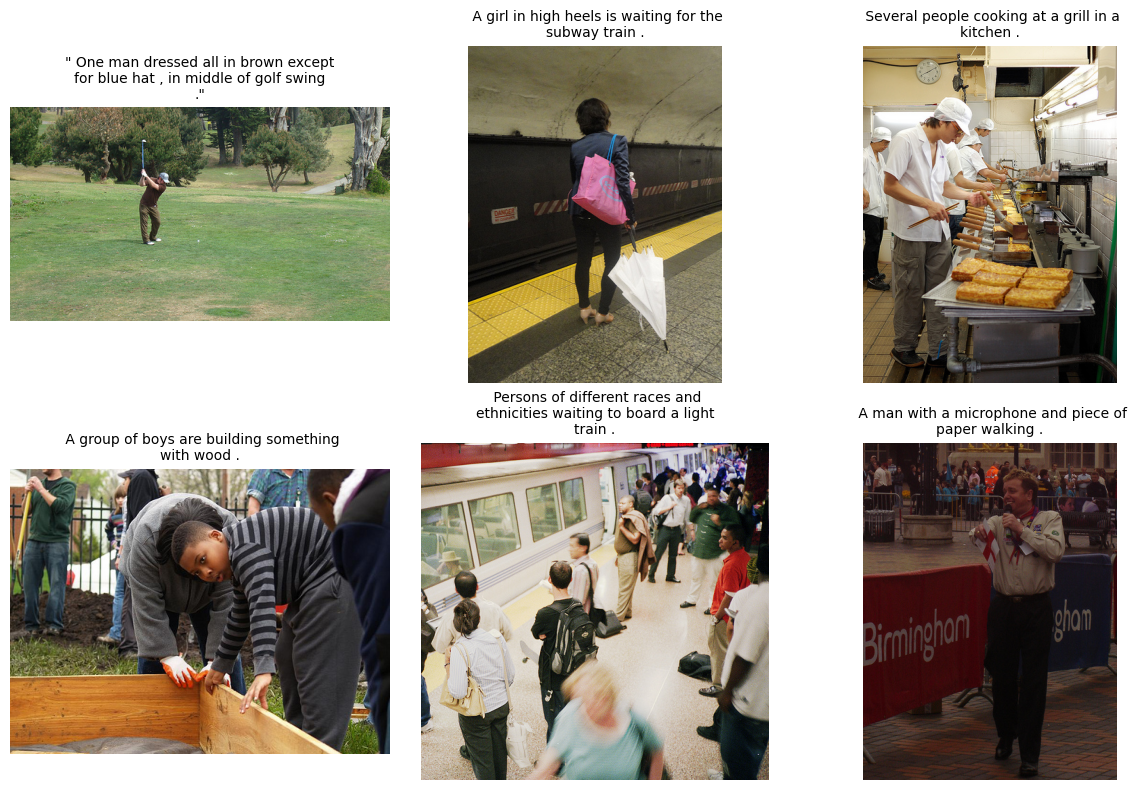

In [3]:
# load data
# Note: the train loader loads duplicate images with a 1:1 mapping of image to captions
# and the val/test loaders load images with a 1:N mapping of image to captions for evaluation
# these loaders will load batches of images rather than all images at once to avoid memory issues
train_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "train"), batch_size=4, eval_mode=False)
val_dir = os.path.join(data_dir, "val")
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# visualize some training images
batch_1 = next(train_loader)
batch_2 = next(train_loader)
dp.visualize_random_captions([batch_1, batch_2])

## Stage One: Pretraining MLP

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# model config for stage one
model = VisionLanguageModel(
    image_encoder_type="vit",
    llava_projections=True,
    cross_attention=False,
    debug=False,
    decoder_type="gpt2",
    d_model=768,
    tokenizer=tokenizer
    ).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Initializing GPT-2 model...


In [ ]:
%%time

max_batches=15000
num_epochs=1

train.train(
    model=model,
    train_dir=train_dir,
    val_dir=val_dir,
    loss_function=loss_fn,
    device=device,
    batch_size=4,
    num_epochs=num_epochs,
    training_type="mlp-pretrain",
    log_interval=1000,
    max_batches=max_batches,
    lr_scheduler=True,
    random_seed=1,
    learning_rate=2e-3,
    mlp_weights_path=os.path.join(model_weights_dir, f"{experiment}_pretrain_weights_{timestamp}.pt"),
    loss_plot_path=os.path.join(evaluations_dir, f"{experiment}_pretrain_loss_{timestamp}.jpg"),
    )

Encoder and decoder weights frozen for LLava-style MLP pre-training.

Epoch 1/1
Step 1000: Loss = 4.0912
Step 2000: Loss = 3.5818
Step 3000: Loss = 3.4757
Step 4000: Loss = 3.4699
Step 5000: Loss = 3.3721
Step 6000: Loss = 3.2905
Step 7000: Loss = 3.2983
Step 8000: Loss = 3.2513
Step 9000: Loss = 3.2277
Step 10000: Loss = 3.2046
Step 11000: Loss = 3.1986
Step 12000: Loss = 3.1606
Step 13000: Loss = 3.1297
Step 14000: Loss = 3.1483
Step 15000: Loss = 3.1209
MLP weights saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/model_weights/experiment_1_pretrain_weights_2025-04-11_10-16-16.pt

Training complete.
CPU times: user 1h 1min 24s, sys: 15.8 s, total: 1h 1min 40s
Wall time: 1h 2min 37s


## Stage Two: Fine-tune

Fine-tuning full decoder and MLP.

Epoch 1/5
Step 1000: Loss = 3.2489
Step 2000: Loss = 3.0827
Step 3000: Loss = 2.9943
Step 4000: Loss = 2.9820
Step 5000: Loss = 2.9507

Epoch 2/5
Step 1000: Loss = 2.5794
Step 2000: Loss = 2.4967
Step 3000: Loss = 2.4383
Step 4000: Loss = 2.4214
Step 5000: Loss = 2.4036

Epoch 3/5
Step 1000: Loss = 2.1081
Step 2000: Loss = 2.0215
Step 3000: Loss = 1.9731
Step 4000: Loss = 1.9343
Step 5000: Loss = 1.9178
Sample Prediction: [' a man in a black hoodie is using a rod to pull a fishing net out of murky water'], Reference: [' A man in waist deep water with a fishing net and wooden box in the river .', ' A man with a fishing net and gear stands waist-high in a body of water .', ' A man is waist deep in water with a fishing net and box .', ' A man is waist deep in a river casting a net .', ' Man in the water with a fishing net and box .']
Epoch 3 - BLEU: 0.0822, CIDEr: 0.1831

Epoch 4/5
Step 1000: Loss = 1.6552
Step 2000: Loss = 1.5905
Step 3000: Loss = 1.556

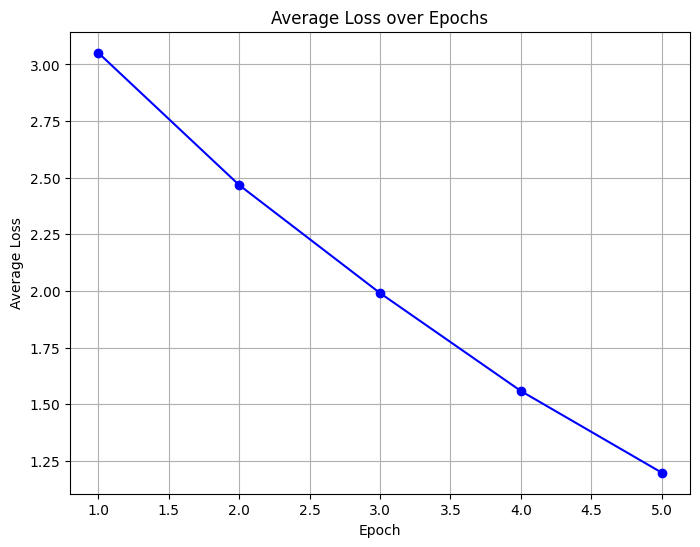

Decoder model saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/model_weights/experiment_1_finetune_weights_2025-04-11_10-16-16.pt

Training complete.
CPU times: user 2h 24min 9s, sys: 25.8 s, total: 2h 24min 35s
Wall time: 2h 25min 32s


In [ ]:
%%time
num_epochs=2
max_batches=3000

train.train(
    model=model,
    train_dir=train_dir,
    val_dir=val_dir,
    loss_function=loss_fn,
    device=device,
    batch_size=4,
    num_epochs=num_epochs,
    training_type="sft",
    max_batches=max_batches,
    log_interval=500,
    learning_rate=2e-4,
    random_seed=16,
    eval_every=2,
    model_weights_path=os.path.join(model_weights_dir, f"{experiment}_finetune_weights_{timestamp}.pt"),
    loss_plot_path=os.path.join(evaluations_dir, f"{experiment}_finetune_loss_{timestamp}.jpg"),
    all_epochs_loss_plot_path=os.path.join(evaluations_dir, f"{experiment}_all_epochs_loss_{timestamp}.jpg")
)

## Evaluate on Test Set

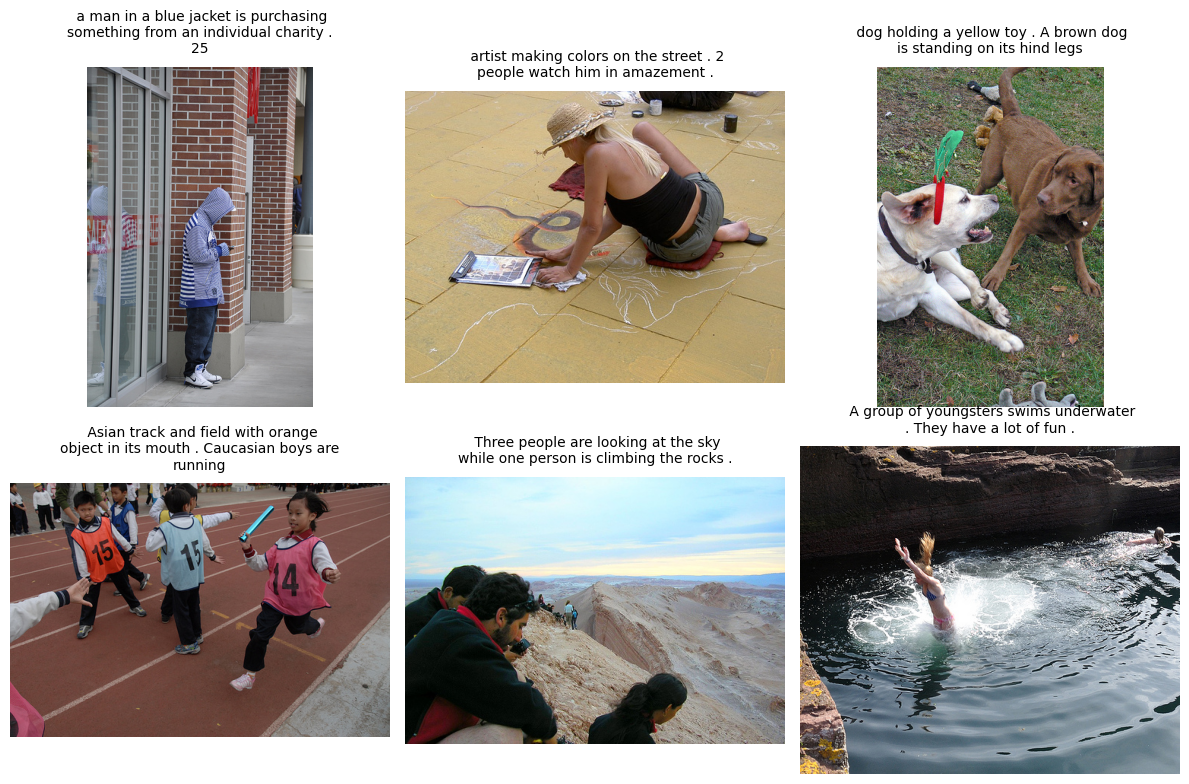

Sample Prediction: [' a man in a blue jacket is purchasing something from an individual charity . 25'], Reference: ['" A man in urban street gear including a striped hoodie looks down at something in his hand , in front of a brick-and-glass storefront ."', ' A person wearing a blue and white hooded jacket playing with a device is standing outside a store with a sale sign on windows .', ' A person in a striped blue and white hooded sweatshirt is standing by a window .', ' A person standing in front of a store is taping on a cellphone .', ' person in striped hoodie and jeans standing in front of store']
BLEU: 0.0810, CIDEr: 0.2069


In [ ]:
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=4, eval_mode=True, seed=32)

bleu_1, cider_1 = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=15,
    max_batches=500,
    num_beams=2
)

print(f"BLEU: {bleu_1:.4f}, CIDEr: {cider_1:.4f}")

In [ ]:
# test with top p sampling
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=4, eval_mode=True, seed=32)

bleu_2, cider_2 = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=15,
    max_batches=500,
    do_sample=True,
    top_p=0.8,
    temperature=0.7
)

In [ ]:
cider = max(cider_1, cider_2)
bleu = max(bleu_1, bleu_2)

# save experiment results
results_path = os.path.join(evaluations_dir, "results.csv")

eval.save_experiment_results(experiment, cider, bleu, results_path)

Results saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/evaluations/results.csv


/content/drive/Othercomputers/My MacBook Pro/image-captioning/evaluation.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
